# Fine-tune TrOCR for mathematical equations

Most of this notebook is an adjusted version of this fine-tuning example: [Fine-tune TrOCR on the IAM Handwriting Database](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/TrOCR/Fine_tune_TrOCR_on_IAM_Handwriting_Database_using_Seq2SeqTrainer.ipynb)

In [1]:
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
Tesla T4, 510.47.03, 15360 MiB


In [2]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 55.0 MB/s eta 0:00:00


In [3]:
!pip install -q datasets jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 90.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 18.2 MB/s eta 0:00:00


## Prepare data

Mount to Google drive to load the prepared dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import pandas as pd
import json
from os.path import join

# Load image names and formula strings from metadata file
with open(join('drive/MyDrive/deeplearning/formula-dataset', 'formula_metadata.json'), 'r') as f:
  metadata_json = json.load(f)
img_names = []
formula_strs = []

for formula in metadata_json['train_formulas']:
  img_names.append(formula['img_name'])
  formula_strs.append(formula['formula_str'])

for formula in metadata_json['test_formulas']:
  img_names.append(formula['img_name'])
  formula_strs.append(formula['formula_str'])

print(len(img_names))
print(len(formula_strs))
# Train dataset example
print(img_names[0])
print(formula_strs[0])
# Test dataset example
print(img_names[1600])
print(formula_strs[1600])

2000
2000
train_formula_0.jpg
6945-8+207
test_formula_0.jpg
7331+95+9


In [11]:
df = pd.DataFrame(list(zip(img_names, formula_strs)), columns=['file_name', 'text'])

In [12]:
df

,file_name,text
0,train_formula_0.jpg,6945-8+207
1,train_formula_1.jpg,53+401
2,train_formula_2.jpg,12957-1-9
3,train_formula_3.jpg,859+90601
4,train_formula_4.jpg,6-5468
...,...,...
1995,test_formula_395.jpg,1386-951977
1996,test_formula_396.jpg,19049+61+2
1997,test_formula_397.jpg,8183+6+126
1998,test_formula_398.jpg,99761+27+181


Split the data into training + testing, using sklearn's `train_test_split` function.

In [13]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)
# Reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

Each element of the dataset should return 2 things:
* `pixel_values`, which serve as input to the model.
* `labels`, which are the `input_ids` of the corresponding text in the image.

We use `TrOCRProcessor` to prepare the data for the model. 

In [14]:
import torch
from torch.utils.data import Dataset
from PIL import Image

# Adjusted for our dataset
class FormulaDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get file name + text 
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # Prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # Add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # Important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [15]:
from transformers import ViTFeatureExtractor

In [22]:
from transformers import TrOCRProcessor

# Split the data to train and evaluation/test dataset
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
train_dataset = FormulaDataset(root_dir='drive/MyDrive/deeplearning/formula-dataset/train/',
                           df=train_df,
                           processor=processor,
                           max_target_length=12)
eval_dataset = FormulaDataset(root_dir='drive/MyDrive/deeplearning/formula-dataset/test/',
                           df=test_df,
                           processor=processor,
                           max_target_length=12)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [23]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 1600
Number of validation examples: 400


### Example from the training dataset



In [24]:
encoding = train_dataset[0]

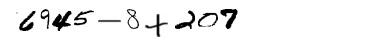

In [25]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
image

In [26]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

6945-8+207


## Fine-tune the model

We used `trocr-base-handwritten` by Microsoft as model to fine-tune since it is already fine-tuned on handwritten text (but not really on mathematical formulas and signs) and the fine-tuning results were much better than using `trocr-small-handwritten`. Fine-tuning `trocr-large-handwritten` would have used more GPU memory than available on the Colab T4 GPUs and take significantily longer to train while not giving much better results.

In [27]:
from transformers import VisionEncoderDecoderModel

model_name = "microsoft/trocr-base-handwritten"
model = VisionEncoderDecoderModel.from_pretrained(model_name)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Importantly, we need to set a couple of attributes, namely:
* the attributes required for creating the `decoder_input_ids` from the `labels` (the model will automatically create the `decoder_input_ids` by shifting the `labels` one position to the right and prepending the `decoder_start_token_id`, as well as replacing ids which are -100 by the pad_token_id)
* the vocabulary size of the model (for the language modeling head on top of the decoder)
* beam-search related parameters which are used when generating text.

In [28]:
# Set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

# Set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

### Training the model

In [29]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=True, 
    output_dir="./",
    logging_steps=2,
    save_steps=1000,
    eval_steps=200,
)

We will evaluate the model on the Character Error Rate (CER).

In [30]:
from datasets import load_metric

cer_metric = load_metric("cer")

<ipython-input-30-c81d87c6f9c2>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")


In [33]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [34]:
from transformers import default_data_collator

trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-384"),
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)

trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Using cuda_amp half precision backend
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1600
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 600
  Number of trainable parameters = 333921792


Step,Training Loss,Validation Loss,Cer
200,0.264400,0.375241,0.075898
400,0.093400,0.208833,0.028292
600,0.094500,0.113301,0.010881


***** Running Evaluation *****
  Num examples = 400
  Batch size = 8
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1,
  "transformers_version": "4.26.0"
}

/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1186: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1,
  "transformers_version": "4.26.0"
}

G

TrainOutput(global_step=600, training_loss=0.4894468604284339, metrics={'train_runtime': 2569.196, 'train_samples_per_second': 1.868, 'train_steps_per_second': 0.234, 'total_flos': 3.5917689167806464e+18, 'train_loss': 0.4894468604284339, 'epoch': 3.0})

In [35]:
# Save the model locally
trainer.save_model('model')

Saving model checkpoint to model
Configuration saved in model/config.json
Configuration saved in model/generation_config.json
Model weights saved in model/pytorch_model.bin
Image processor saved in model/preprocessor_config.json


In [ ]:
# Save the model on Google Drive
trainer.save_model('/content/drive/MyDrive/file-path')

## Inference

In [37]:
# Same tokenizer used during fine-tuning used to preprocess the input images for the model
tokenizer = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-384")

loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-384/snapshots/be89a4abf1f427fe502d37f261b8b6d6da7894bc/preprocessor_config.json
size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'shortest_edge', 'longest_edge'}), got 384. Converted to {'height': 384, 'width': 384}.
Image processor ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 384,
    "width": 384
  }
}



In [38]:
import random

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1,
  "transformers_version": "4.26.0"
}

/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 64 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


8-853-4056


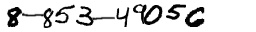

In [39]:
# Load a random image from a different collection of formula images
rand_img = 'formula_' + str(random.randint(2000, 20000)) + '.jpg'
url = join('/content/drive/MyDrive/dlproject/dataset/formula-imgs/', rand_img)
image = Image.open(url).convert("RGB")

# Convert to pixel values
pixel_values = tokenizer(image, return_tensors="pt").pixel_values
pixel_values = pixel_values.cuda()

# Running the OCR inference
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)
image